In [81]:
#import pertinent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

# Import the data

In [82]:
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/machine_learning_data/data.csv')
test_data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/machine_learning_data/test_data.csv')

In [83]:
data.shape, test_data.shape

((1044, 257), (262, 257))

In [84]:
data.outcome.value_counts(),test_data.outcome.value_counts()

(outcome
 0.0    731
 1.0    313
 Name: count, dtype: int64,
 outcome
 0.0    174
 1.0     88
 Name: count, dtype: int64)

# Setup the black box testing set 
The model will not see this data during training

In [85]:
# setup the testing data
X_test, y_test = test_data.drop(columns='outcome'), test_data.outcome

In [86]:
X_test.shape, y_test.shape

((262, 256), (262,))

In [87]:
# preprocess the target variable separately

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

target =le.fit_transform(data.outcome)
y_test = le.transform(test_data.outcome)

## Create the training and validation set 
Validation sets are used with XGBoost, which offers early stopping if the error rate increases, for validation or training

In [88]:
from sklearn.model_selection import train_test_split

# set the x and y variables
X = data.drop(columns=['outcome'], axis=1)
y = target

# split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [89]:
pd.Series(y_train).value_counts(), pd.Series(y_val).value_counts()

(0    590
 1    245
 Name: count, dtype: int64,
 0    141
 1     68
 Name: count, dtype: int64)

### Fit the model

In [90]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 
from xgboost import XGBClassifier

In [91]:
parameters = [
    {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
]

grid_search = GridSearchCV(XGBClassifier(), 
                                        parameters,
                                        verbose=True, 
                                        scoring='f1', 
                                        cv=StratifiedShuffleSplit(n_splits=5),
                                        n_jobs=8)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=8,
             param_grid=[{'learning_rate': [0.1, 0.01, 0.001],
                          'n_estimators': [150, 200, 300]}],
             scoring='f1', verbose=True)

Measure the F1 Score, which is the harmonic mean of precision and recall

In [92]:
print("Best score: %0.3f" % grid_search.best_score_)


Best score: 0.785


In [93]:
best_parameters = grid_search.best_estimator_.get_params()

best_parameters

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

## Choose the ideal set of parameters to run the model with the best accuracy

In [94]:
#print the accuracy for each parameter combination\n",
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.775 (+/-0.106) for {'learning_rate': 0.1, 'n_estimators': 150}
0.780 (+/-0.100) for {'learning_rate': 0.1, 'n_estimators': 200}
0.783 (+/-0.096) for {'learning_rate': 0.1, 'n_estimators': 300}
0.746 (+/-0.076) for {'learning_rate': 0.01, 'n_estimators': 150}
0.764 (+/-0.115) for {'learning_rate': 0.01, 'n_estimators': 200}
0.785 (+/-0.131) for {'learning_rate': 0.01, 'n_estimators': 300}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 150}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 200}
0.000 (+/-0.000) for {'learning_rate': 0.001, 'n_estimators': 300}


In [95]:
#refit model with all data
clf = XGBClassifier(n_estimators=300,
                    max_depth=3,
                     learning_rate=0.1,
                     n_jobs=8,
                   importance_type='coverage')

clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_val,y_val)],eval_metric=["auc","error"], verbose=False)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type='coverage',
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=8,
              num_parallel_tree=None, random_state=None, ...)

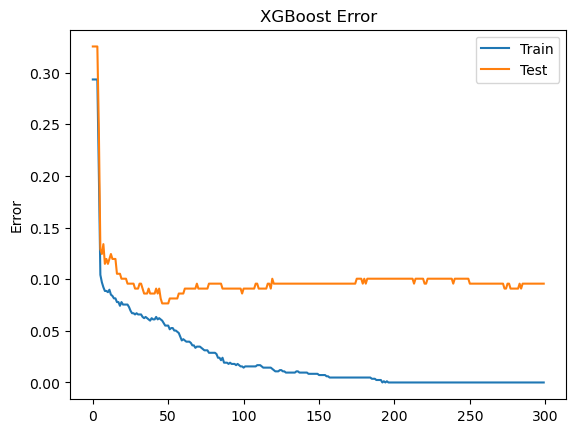

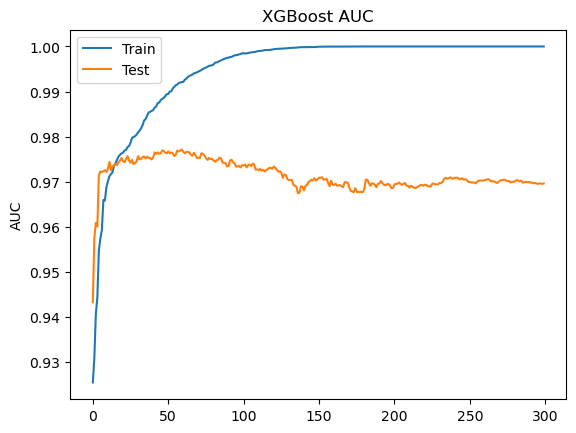

In [96]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()


### Evaluate the fitted model

In [97]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle
from scipy import interp

In [98]:
y_pred_train = clf.predict(X_train)
y_pred_val = clf.predict(X_val)
y_pred_test = grid_search.predict(X_test)

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_val)
y_test_prob = clf.predict_proba(X_test)

In [99]:
print(classification_report(y_val,y_pred_val))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       141
           1       0.93      0.76      0.84        68

    accuracy                           0.90       209
   macro avg       0.91      0.87      0.89       209
weighted avg       0.91      0.90      0.90       209



In [100]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       174
           1       0.82      0.85      0.83        88

    accuracy                           0.89       262
   macro avg       0.87      0.88      0.87       262
weighted avg       0.89      0.89      0.89       262



In [101]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       590
           1       1.00      1.00      1.00       245

    accuracy                           1.00       835
   macro avg       1.00      1.00      1.00       835
weighted avg       1.00      1.00      1.00       835



In [102]:
# Measure F1 score for training, validation and testing
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 1.000
Validation Accuracy: 0.904
Test Accuracy: 0.885


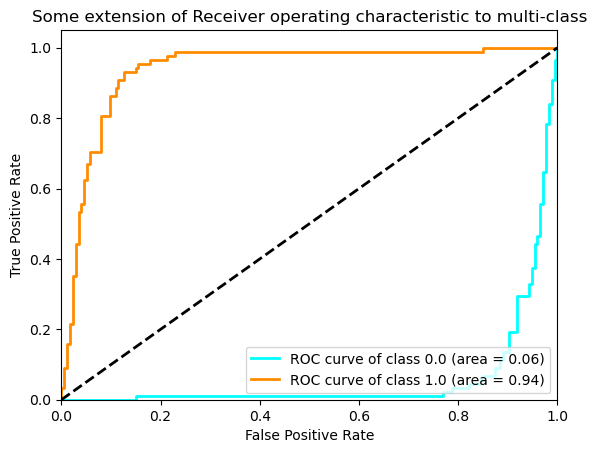

In [103]:
# Plot all ROC curves

from sklearn.preprocessing import label_binarize
#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

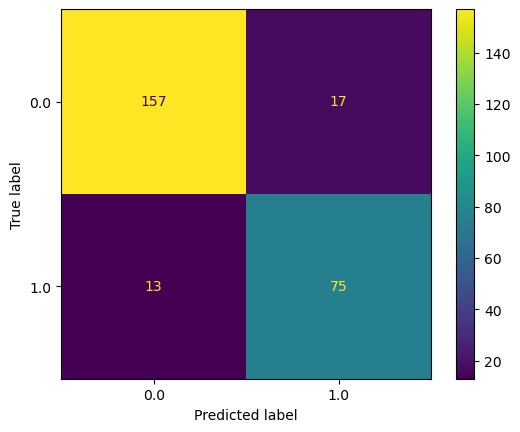

In [104]:
# creat confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()
plt.show();



In [105]:
import shap

# load JS visualization code to notebook
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

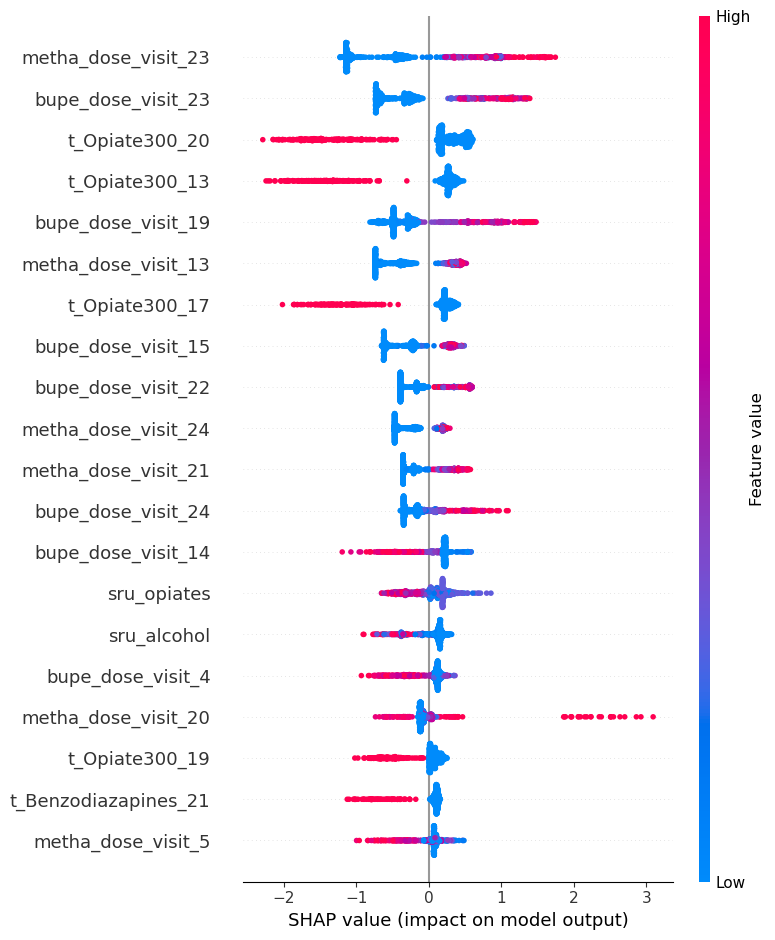

In [106]:
# # shap.force_plot(explainer.expected_value, shap_values, X_smt)
shap.summary_plot(shap_values, X_train, feature_names = X_train.columns,  max_display=20, plot_type="dot")

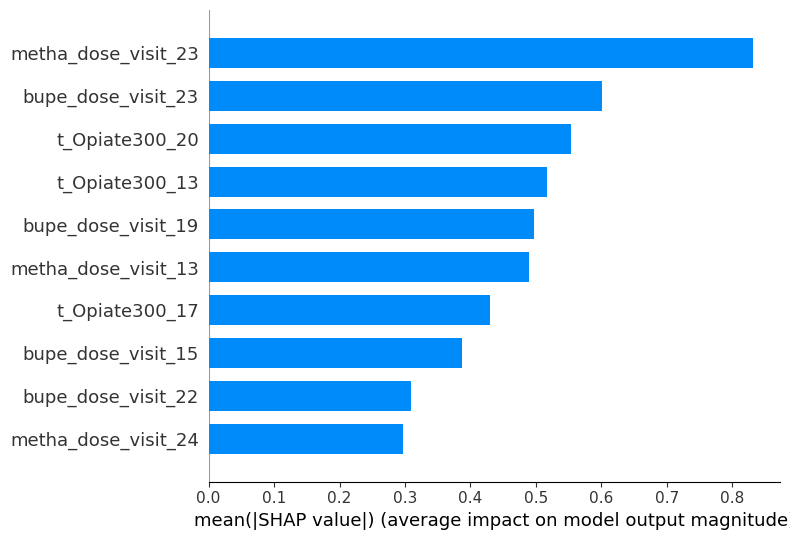

In [107]:
# create shap beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=10)

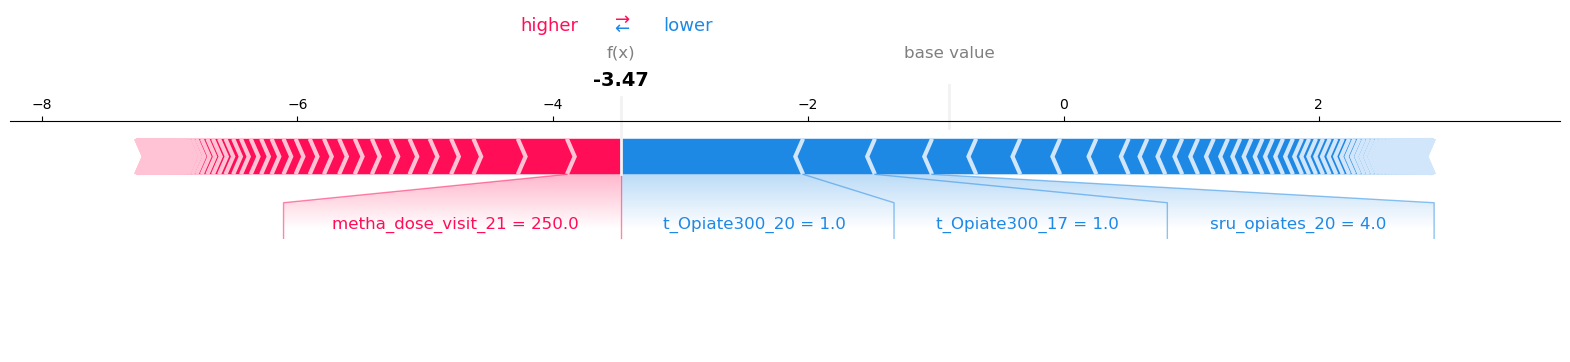

In [73]:
# create shap force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:],matplotlib=True, show=False,)
